## Plots and tables

In [1]:
import numpy as np
import pandas as pd
import os
from time import time
import gzip, pickle
import datetime
from scipy.ndimage.filters import gaussian_filter
from cogent3 import make_table
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

np.set_printoptions(precision=2)
projdir = "/Users/helmutsimon/repos/bayescoalescentest/shared"
if not os.getcwd() == projdir:
    os.chdir(projdir)
from MCMC_functions import multiply_variates, ancestral_process, print_pds

In [11]:
path = "/Users/helmutsimon/Google Drive/Genetics/bayes_coalescent_est/data"
if not os.getcwd() == path:
    os.chdir(path)

job_no = 'sp020'
file_path = 'tree_simulations_' + job_no

with gzip.open(file_path, 'rb') as results:
    results = pickle.load(results)
sfs, true_branch_lengths, empirical_prior, mu, sd = results[:5]
print(sfs)    
    
job_no = 'rbm_sp020'

fname = 'branch_vars_' + job_no + '.pklz'
with gzip.open(fname, 'rb') as brvars:
    brvars = pickle.load(brvars)

print(brvars.shape)
n = brvars.shape[0] + 1

ttl = np.sum(np.arange(2, n + 1) * true_branch_lengths)
print(ttl)
properties = dict()
properties['Author'] = 'Helmut Simon'

[36, 4, 32, 0, 13, 0, 0]
(7, 1000000)
15029453.372839319


Plot branch lengths

In [ ]:
pdfname = 'brfig' + job_no + 'a.pdf'
properties['Title'] = 'Posterior distribution of branch lengths'
properties['Subject'] = 'Datafile: ' + fname
labels = np.arange(2, n + 1)
fig = print_pds(pdfname, brvars, labels, truevalues=true_branch_lengths, properties=properties, \
                         savepdf=True, xlim=500)
plt.show()
print(true_branch_lengths)
print(np.mean(brvars, axis=1))
print(np.std(brvars, axis=1))

Plot coalescence times as line plots

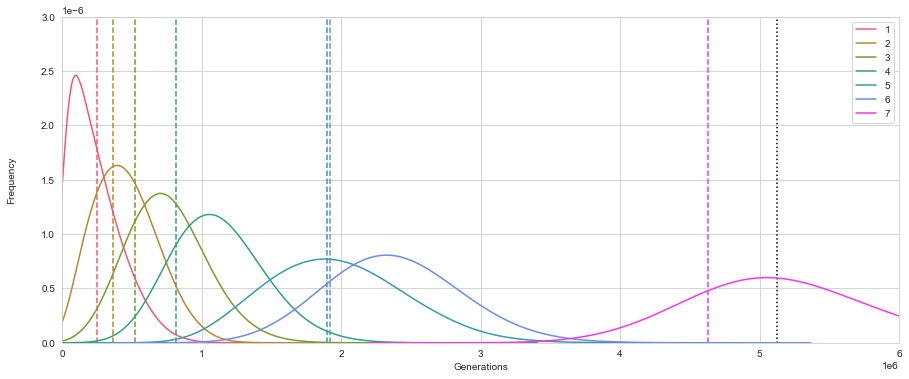

5125000.0
322344.92395569064
[ 247018.37  363153.31  519862.72  814569.53 1902464.95 1922534.6
 4629924.95]
[ 233008.95  454575.37  751787.31 1118308.35 1963365.52 2375728.62
 5147178.36]


In [12]:
branches_rev = np.flipud(brvars)
coal_times = np.cumsum(branches_rev, axis=0)
true_coal_times =  np.cumsum(true_branch_lengths[::-1])
#true_coal_times = None
length = 1e3
mrate = 5e-9
seq_mutation_rate = length * mrate
n_seq = np.arange(1, n)
thom = np.sum(sfs * n_seq) / (n * seq_mutation_rate)
var_thom = np.sum(sfs * n_seq * n_seq) / (2 * n * seq_mutation_rate) ** 2

pdfname = 'coalfig' + job_no + '.pdf'
properties['Title'] = 'Posterior distribution of coalescence times.'
properties['Subject'] = 'Datafile: ' + fname
labels = np.arange(1, n)
fig = print_pds(pdfname, coal_times, labels, truevalues=true_coal_times, properties=properties,\
                         savepdf=True, thom=thom, xlim=6e6, ylim=3e-6)
plt.show()
print(thom)
print(np.sqrt(var_thom))
print(true_coal_times)
print(np.mean(coal_times, axis=1))

Plot coalescence times as heatmap

In [ ]:
job_no = 'ncn55_00f01'
fname = '/Users/helmutsimon/Google Drive/Genetics/bayes_coalescent_est/data/branch_vars_' + job_no + '.pklz'
with gzip.open(fname, 'rb') as branch_vars:
    brvars = pickle.load(branch_vars)

n = brvars.shape[0] + 1

tmrca_est = np.sum(np.mean(brvars, axis=1))
print('Est. TMRCA  = '.ljust(35), tmrca_est)

ntimes = 1000
tlim = 1000
xstep = 20
branches_rev = np.flipud(brvars)
coal_times = np.cumsum(branches_rev, axis=0)
print(np.mean(brvars,axis =1))
print(np.mean(coal_times,axis =1))
draws = coal_times.shape[1]  

heatmap_table = list()
for row in coal_times:
    hist_row , bin_edges= np.histogram(row, bins=ntimes, range=(0, tlim), density=True)
    hist_row = hist_row / np.max(hist_row)  #equalize the range
    heatmap_table.append(hist_row)
heat_table = pd.DataFrame(heatmap_table)
print(heat_table.index)
newindex = heat_table.index[::-1]
heat_table = heat_table.reindex(index=newindex)
print(heat_table.index)
heat_table = gaussian_filter(heat_table, sigma=2)
path = '/Users/helmutsimon/Google Drive/Genetics/bayes_coalescent_est/data/'
pdfname = path + 'coal_heatmap_' + job_no + '.pdf'
properties = dict()
properties['Author'] = 'Helmut Simon'
properties['Title'] = 'Coalescence times heatmap.'
properties['Subject'] = 'Datafile: ' + fname
with PdfPages(pdfname) as pdf:
    fig = plt.figure(figsize=(15, 6))
    sns.heatmap(heat_table, vmin=0, vmax=1.1, cmap="cubehelix",\
                cbar_kws={'label': 'Adjusted probability density'}, linewidth=0)
    plt.xticks(np.arange(0, ntimes, xstep), np.arange(0, tlim, tlim * xstep / ntimes, dtype='int'), fontsize=12)
    plt.xlim([0, ntimes])
    plt.xlabel('Generations before present', fontsize=12, labelpad=12)
    plt.yticks(np.arange(n-2, -1, -2), np.arange(2, n+1, 2, dtype='int'))
    plt.ylabel('Order of coalescent event from present', fontsize=12)
    ymax = plt.gca().get_ylim()
    shrink = ntimes / tlim
    plt.vlines(tmrca_est * shrink, 0, n + 1, colors='r', linewidth=0.5)
    d = pdf.infodict()
    for key in properties:
        d[key] = properties[key]
    pdf.savefig(fig, bbox_inches='tight')
plt.show()

Plot ancestral process

In [ ]:
ntimes = 200
tlim = 1e5
x_values = np.linspace(0, tlim, num=ntimes)

#a_proc = ancestral_process(brvars, ntimes, tlim)
sns.set_style("whitegrid")
cols = sns.husl_palette(n_colors=n - 1, s=0.9, l=0.6)
labels = np.arange(n, 1, -1)
pdfname = 'anc_fig_' + job_no + '.pdf'
properties['Title'] = 'Ancestral process.'
with PdfPages(pdfname) as pdf:
    fig = plt.figure(figsize=(15, 6))
    for row, col, label in zip(a_proc, cols, labels):
        sns.lineplot(x=x_values, y=row, color=col, label=label)
    plt.xlabel('Generations')
    plt.ylabel('Probability')
    plt.xlim([0, 1e5]) 
    plt.legend()
    plt.vlines(true_coal_times, 0, 1, colors=cols, linestyles='dashed')
    d = pdf.infodict()
    for key in properties:
        d[key] = properties[key]
    pdf.savefig(fig, bbox_inches='tight')
plt.show()

Plot posterior distribution of TMRCA

In [ ]:
pdfname = 'tmrca_8_25_v_8_26.pdf'
properties['Title'] = 'Comparison of TMRCA posterior distributions'
properties['keywords'] = 'jobs 8_10 & 8_11'
palette = sns.color_palette("colorblind", 2)
col0 = palette[0]
col1 = palette[1]
with PdfPages(pdfname) as pdf:
    fig = plt.figure(figsize=(10, 6))
    job_no = 'ncn8_25'
    #job_no = 'sp35'
    fname = 'branch_vars_' + job_no + '.pklz'
    with gzip.open(fname, 'rb') as brvars:
        brvars = pickle.load(brvars)
    tmrca_vars = np.sum(brvars, axis=0)
    sns.kdeplot(tmrca_vars, color=col0, label='Fixed mutation rate')

    print("%.1f" % np.mean(tmrca_vars))
    print("%.1f" % np.quantile(tmrca_vars, 0.025))
    print("%.1f" % np.quantile(tmrca_vars, 0.975))
    print("%.1f" % np.std(tmrca_vars))
    ymax = plt.gca().get_ylim()[1]
    print(ymax)
    plt.vlines(np.quantile(tmrca_vars, 0.025), 0, ymax, colors=col0, linestyle='dotted')
    plt.vlines(np.quantile(tmrca_vars, 0.975), 0, ymax, colors=col0, linestyle='dotted')
    
    job_no = 'ncn8_26'
    fname = 'branch_vars_' + job_no + '.pklz'
    with gzip.open(fname, 'rb') as brvars:
        brvars = pickle.load(brvars)
    tmrca_vars = np.sum(brvars, axis=0)
    sns.kdeplot(tmrca_vars, color=col1, label='Uncertain mutation rate')

    print("%.1f" % np.mean(tmrca_vars))
    print("%.1f" % np.quantile(tmrca_vars, 0.025))
    print("%.1f" % np.quantile(tmrca_vars, 0.975))
    print("%.1f" % np.std(tmrca_vars))

    plt.vlines(np.quantile(tmrca_vars, 0.025), 0, ymax, colors=col1, linestyle='dotted')
    plt.vlines(np.quantile(tmrca_vars, 0.975), 0, ymax, colors=col1, linestyle='dotted')

    plt.vlines(thom, 0, ymax, colors='k', linestyle='dotted', label='Thomson estimate of TMRCA')

    plt.xlim([0, 2000])
    plt.ylim([0, ymax])
    plt.xlabel('Generations')
    plt.ylabel('Probability')
    plt.yticks([])
    plt.legend()
    plt.show()
    print("%.1f" % np.mean(tmrca_vars))
    print("%.1f" % np.quantile(tmrca_vars, 0.025))
    print("%.1f" % np.quantile(tmrca_vars, 0.975))
    print("%.1f" % np.std(tmrca_vars))
    
    d = pdf.infodict()
    for key in properties:
        d[key] = properties[key]
    pdf.savefig(fig, bbox_inches='tight')
plt.show()

In [ ]:
a_proc_df = pd.DataFrame(a_proc)
a_proc_df.to_csv('anc_proc_' + job_no + '.csv')

Create heatmap of ancestral process.

In [ ]:
path = "/Users/helmutsimon/Google Drive/Genetics/bayes_coalescent_est/data"
if not os.getcwd() == path:
    os.chdir(path)

!scp helmut@fisher.rsb.anu.edu.au:./helmutsimonpython/helmutsimonpython/bayes_sfs/data/sample_tree_matrices.py_stmf050.log .
!scp helmut@fisher.rsb.anu.edu.au:./helmutsimonpython/helmutsimonpython/bayes_sfs/data/mxs_stmf050 .

In [ ]:
job_no = 'sp20_03'
fname = '/Users/helmutsimon/Google Drive/Genetics/bayes_coalescent_est/data/branch_vars_' + job_no + '.pklz'
with gzip.open(fname, 'rb') as branch_vars:
    brvars = pickle.load(branch_vars)

n = brvars.shape[0] + 1

print('Est. branch lengths    = '.ljust(35), np.mean(brvars, axis=1))
tmrca_est = np.sum(np.mean(brvars, axis=1))
print('Est. TMRCA  = '.ljust(35), tmrca_est)

ntimes = 200
tlim = 1200
step = tlim / ntimes
x_values = np.linspace(0, tlim, num=ntimes)

a_proc = ancestral_process(brvars, ntimes, tlim)
heat_table = pd.DataFrame(a_proc, index=np.arange(n, 0, -1))
path = '/Users/helmutsimon/Google Drive/Genetics/bayes_coalescent_est/data/'
pdfname = path + 'anc_heatmap_' + job_no + '.pdf'
properties = dict()
properties['Author'] = 'Helmut Simon'
properties['Title'] = 'Ancestral process heatmap.'
properties['Subject'] = 'Datafile: ' + fname
with PdfPages(pdfname) as pdf:
    fig = plt.figure(figsize=(15, 6))
    sns.heatmap(heat_table, vmin=0, vmax=0.5, cmap="cubehelix", cbar_kws={'label': 'Probability'}, linewidth=0)
    plt.xticks(np.arange(0, ntimes, 8), np.arange(0, tlim, tlim * 8 / ntimes))
    plt.xlim([0, ntimes])
    plt.xlabel('Generations before present')
    plt.ylabel('$k$ (number of extant ancestors)')
    ymax = plt.gca().get_ylim()
    shrink = ntimes / tlim
    plt.vlines(tmrca_est * shrink, 0, n + 1, colors='r', linewidth=0.5)
    d = pdf.infodict()
    for key in properties:
        d[key] = properties[key]
    pdf.savefig(fig, bbox_inches='tight')
plt.show()

Table of posterior mean estimates from Nuu-Chah-Nulth data

In [ ]:
from cogent3 import make_table

brlens = np.array([[209.23, 110.91, 103.5,   66.37,  55.11,  52.83,  45.32, 0],\
                   [238.87, 147.33, 140.1,   88.87,  71.36,  67.34,  57.58, 0]])
           
brlens[0, -1] = np.sum(brlens[0,:-1])
brlens[1, -1] = np.sum(brlens[1,:-1])
#brlens[2, -1] = np.sum(brlens[2,:-1])

columns = ['k=' + str(i) for i in np.arange(2, 9)] + ['TMRCA']
#index = ['Fixed mutation rate', 'Uncertainty in mutation rate', 'Wright-Fisher']
index = ['Fixed mutation rate', 'Uncertainty in mutation rate']
brlens = pd.DataFrame(brlens, columns=columns)
brlens.insert(loc=0, column='', value=index)
print(brlens)
t = make_table(data_frame=brlens, \
               title="Posterior mean estimates of branch lengths and the TMRCA for the sub-sample of 8 \
mitochondrial sequences from the Nuu-Chah-Nulth population. Estimates with and without \
taking account of uncertainty in the estimate of mutation rate are shown.")
for c in columns:
    t.format_column(c, "%.1f")
t.write("ncn_brl.tex", label="tab:ncn_brl", justify="lccccccccc")
t

Table comparing results using Dirichlet and MVN prior distributions.

In [ ]:
def get_tab_row(job_no):
    fname = 'compare_priors_result_' + job_no + '.csv'
    #fname = 'Table_compare_priors.csv'
    results = pd.read_csv(fname, sep=',', index_col=0)
    results.iloc[:,4:] = results.iloc[:,4:].apply(pd.to_numeric)
    results['tmrca_Dir_mse'] = (results['tmrca_true'] - results['tmrca_Dir']) ** 2
    results['tmrca_mvn_mse'] = (results['tmrca_true'] - results['tmrca_mvn']) ** 2
    results['tmrca_thom_mse'] = (results['tmrca_true'] - results['thom']) ** 2
    totals = results.mean(axis=0)
    totals['tmrca_Dir_mse'] = np.sqrt(totals['tmrca_Dir_mse'])
    totals['tmrca_mvn_mse'] = np.sqrt(totals['tmrca_mvn_mse'])
    totals['tmrca_thom_mse'] = np.sqrt(totals['tmrca_thom_mse'])
    #path = "/Users/helmutsimon/Google Drive/Genetics/bayes_coalescent_est/data"
    return totals


path = "/Users/helmutsimon/Google Drive/Genetics/bayes_coalescent_est/data"
if not os.getcwd() == path:
    os.chdir(path)
    
job_no = 'sm206'
totals1 = get_tab_row(job_no)
job_no = 'sm207'
totals2 = get_tab_row(job_no)
totals = pd.DataFrame([totals1, totals2])
print(totals)
totals.drop(labels=['tmrca_true','tmrca_Dir','tmrca_mvn','thom'], axis=1, inplace=True)
print(totals)
#header1 = ['$S_n$', 'branch lengths', 'branch lengths', 'TMRCA', 'TMRCA', 'TMRCA'] 
#header2 = ['', 'Dirichlet', 'MVN', 'Dirichlet', 'MVN', 'Thomson']
#totals.columns = pd.MultiIndex.from_arrays([header1, header2])
#print(totals)
t = make_table(data_frame=totals, title="title blah")
#t = make_table(data_frame=totals)
justify = "r" * (totals.shape[1] )
for c in totals.columns:
    t.format_column(c, "%.1f")
#results[results.columns[5]] = results[results.columns[5]].apply(pd.to_numeric)
fname = 'cptab_' + job_no + '.tex'
label = 'tab:cp' 
t.write(fname, label=label, justify=justify)
t

Plot tree levels

In [ ]:
fname = '/Users/helmutsimon/Google Drive/Genetics/bayes_coalescent_est/data/pm_trace_ncn55_00f01.csv'
#trace = pd.read_csv(fname, index_col=0, sep=',', na_filter=False)
level  = 0
label = 'index_' + str(level)
index = trace[label] 
counts = np.bincount(index)
for i, c in enumerate(counts):
    print(i + 1, "%.3f" % (c / 1.2e6))
pdfname = '/Users/helmutsimon/Google Drive/Genetics/bayes_coalescent_est/data/tree_index_plot_' + str(level) + '.pdf'
with PdfPages(pdfname) as pdf:
    fig = plt.figure(figsize=(30, 10))
    sns.barplot(x=np.arange(1, 55 - level), y=counts, color='b')
    yticklabels = ["%.2f" % i for i in np.arange(0, 350000 / 1200000, 50000/1200000)]
    plt.xticks(fontsize=20)
    plt.xlabel('Partition size', fontsize=24, labelpad=20)
    plt.yticks(np.arange(0, 350000, 50000), yticklabels, fontsize=20)
    plt.ylabel('Probability', fontsize=24, labelpad=20)
    #pdf.savefig(fig, bbox_inches='tight')
plt.show()

In [ ]:
labels
